## LASSO + XGBoost PRS method 

In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
from pandas_plink import read_plink
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt


pd.set_option('display.float_format', '{:.4f}'.format)


In [65]:
# read and process genotype and phenotype data

def read_genotype_phenotype_data(genotype_data_path, phenotype_data_path):
    bim, fam, bed = read_plink(genotype_data_path)
    genotype_df = bed.compute().T.astype(np.float64)

    genotype_df = pd.DataFrame(genotype_df)
    genotype_df.columns = bim['snp'].values

    phenotype_df = pd.read_csv(phenotype_data_path, sep=' ', header=None)
    
    
    phenotype_df.columns = ['A', 'B', 'C', 'D', 'E', 'Height']
    FIDs = phenotype_df['A'].values
    phenotype_df = phenotype_df.drop(columns=['A', 'B', 'C', 'D', 'E'])

    
    merged_df = pd.concat([genotype_df, phenotype_df], axis=1)

    return genotype_df, phenotype_df, merged_df, FIDs


In [66]:
# Read genotype and phenotype data for train, val, and test datasets
genotype_df_train, phenotype_df_train, merged_train, FIDs_train = read_genotype_phenotype_data('../data/train_data_VN', '../data/train_data_VN.fam')
genotype_df_val, phenotype_df_val, merged_val, FIDs_val = read_genotype_phenotype_data('../data/val_data_VN', '../data/val_data_VN.fam')
genotype_df_test, phenotype_df_test, merged_test, FIDs_test = read_genotype_phenotype_data('../data/test_data_VN', '../data/test_data_VN.fam')


Mapping files: 100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


In [4]:
# Read GWAS summary statistics
sumstat_df_VN = pd.read_csv('../data/VN_train_sumstats.ss', sep=' ', header=0)
sumstat_df_UK = pd.read_csv('../data/UKBB_height_sumstats.ss', sep='\t', header=0)
sumstat_df_JPN = pd.read_csv('../data/JPN_height_sumstat.ss', sep='\t', header=0)


In [88]:
# Create X and y DataFrames
X_train = merged_train.drop('Height', axis=1)
y_train = merged_train['Height']

X_val = merged_val.drop('Height', axis=1)
y_val = merged_val['Height']

X_test = merged_test.drop('Height', axis=1)
y_test = merged_test['Height']


In [89]:
# Get a list of columns with more than 300 missing values
cols_to_drop = [col for col in X_train.columns if X_train[col].isnull().sum() > 300]

# Drop the columns from X_train and X_test and X_val
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)

In [90]:
# Create an imputer object with median strategy
imputer = SimpleImputer(strategy='median')

# Impute missing values in the training set
X_train_imputed = imputer.fit_transform(X_train)

# Impute missing values in the validation and test sets using the same imputer
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Convert imputed NumPy arrays back to DataFrames
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_val = pd.DataFrame(X_val_imputed, columns=X_val.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)


In [91]:
# Reorder columns for sumstat_df_UK and sumstat_df_JPN to match sumstat_df_VN
sumstat_df_UK = sumstat_df_UK[['CHR', 'SNP', 'BP', 'N', 'BETA', 'SE', 'P', 'A1', 'A2', 'MAF']]
sumstat_df_JPN = sumstat_df_JPN[['CHR', 'SNP', 'BP', 'N', 'BETA', 'SE', 'P', 'A1', 'A2', 'MAF']]

# Standardize column names
column_names = ['CHR', 'SNP', 'BP', 'N', 'BETA', 'SE', 'P', 'A1', 'A2', 'MAF']

sumstat_df_VN.columns = column_names
sumstat_df_UK.columns = column_names
sumstat_df_JPN.columns = column_names

# sumstat_dfs = [sumstat_df_VN, sumstat_df_UK, sumstat_df_JPN]
sumstat_dfs_0 = [sumstat_df_UK, sumstat_df_JPN]


In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [93]:
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [12]:
# Create a dictionary containing all the variables
data_to_save = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

# Save the dictionary to a file
with open('all_data_cp7.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [94]:
y_test = test_merged_df_final['Height_y']


In [95]:
def get_lasso_mse(alpha, geno_df_snps, y, k, common_snps):
    # LASSO feature selection
    lasso_cv = LassoCV(alphas=[alpha], max_iter=10000, cv=8, n_jobs=-1)
    lasso_cv.fit(geno_df_snps, y)
    lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
    lasso.fit(geno_df_snps, y)

    snp_coefficients = list(zip(common_snps, lasso.coef_))

    # Filter SNPs with top k absolute coefficients
    selected_snps_alpha = [snp for snp, coef in sorted(snp_coefficients, key=lambda x: abs(x[1]), reverse=True)[:k]]

    # Train a LASSO model using the selected SNPs and calculate the mean squared error
    X_train_selected = geno_df_snps[selected_snps_alpha]

    lasso_full = Lasso(alpha=alpha, max_iter=10000)
    lasso_full.fit(X_train_selected, y)
    mse = mean_squared_error(y, lasso_full.predict(X_train_selected))

    return mse, selected_snps_alpha, alpha, snp_coefficients

def get_lasso_selected_snps(ss_df0, geno_df, y, k=100):
    selected_snps = []
    alphas = np.logspace(-4, 1, 20)
    best_alpha = None
    best_mse = float('inf')

    ss_df0 = ss_df0[ss_df0['P'] < 1e-4]

    # Filter the geno_df for SNPs present in both sumstat_df and geno_df
    snps = ss_df0['SNP'].values
    common_snps = list(set(snps) & set(geno_df.columns))
    geno_df_snps = geno_df.loc[:, common_snps]

    results = Parallel(n_jobs=-1)(delayed(get_lasso_mse)(alpha, geno_df_snps, y, k, common_snps) for alpha in alphas)

    all_coefficients = []
    for mse, selected_snps_alpha, alpha, snp_coefficients in results:
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
            selected_snps = selected_snps_alpha

            print("best mse:", best_mse, "best alpha:", best_alpha)
        all_coefficients.extend(snp_coefficients)

    # Create a DataFrame with all SNPs and their coefficients
    all_coefficients_df = pd.DataFrame(all_coefficients, columns=['SNP', 'Coefficient'])
    print(all_coefficients_df)
    
    return selected_snps, best_alpha, all_coefficients_df


def xgboost_cv(X, y, params, nfold=3, early_stopping_rounds=10, ntree_limit=None):
    dtrain = xgb.DMatrix(X, label=y)
    cv_result = xgb.cv(params, dtrain, num_boost_round=ntree_limit, nfold=nfold, early_stopping_rounds=early_stopping_rounds, seed=42, nthread=-1)
    return cv_result

def train_single_ensemble_model(ss_df, X_train, y_train, X_val, y_val, lasso_output_file_cp7):
    # LASSO feature selection
    selected_snps, optimal_alpha, all_coefficients_df = get_lasso_selected_snps(ss_df, X_train, y_train)
    X_train_selected = X_train[selected_snps]
    
    # Save LASSO outputs to a file
    lasso_output = (selected_snps, optimal_alpha, all_coefficients_df)
    with open(lasso_output_file_cp7, 'wb') as f:
        pickle.dump(lasso_output, f)
        
    # XGBoost model
    params = {
        'learning_rate': 0.05,
        'max_depth': 5,
        'colsample_bytree': 0.9,
        'min_child_weight': 10,
        'subsample': 0.5,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'nthread': -1
    }
    
    print("Starting XGBoost!")

    dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
    cv_result_selected = xgb.cv(params, dtrain_selected, num_boost_round=10000, nfold=3, early_stopping_rounds=10, seed=42)

    # Validation set
    X_val_selected = X_val[selected_snps]
    dval_selected = xgb.DMatrix(X_val_selected, label=y_val)

    best_ntree_limit = cv_result_selected.shape[0]
    evals = [(dtrain_selected, "train"), (dval_selected, "validation")]
    model = xgb.train(params, dtrain_selected, num_boost_round=best_ntree_limit, evals=evals)

    print(all_coefficients_df)
    return model, selected_snps, all_coefficients_df


def train_ensemble_models(my_sumstat_dfs, X_train, y_train, X_val, y_val, n_jobs=20):
    
    # Generate unique output file names for each LASSO output
    lasso_output_files_cp7 = [f"lasso_output_cp7_{i}.pkl" for i in range(len(my_sumstat_dfs))]

    models_snps = Parallel(n_jobs=n_jobs)(delayed(train_single_ensemble_model)(sumstat_df, X_train, y_train, X_val, y_val, lasso_output_file_cp7) for sumstat_df, lasso_output_file_cp7 in zip(my_sumstat_dfs, lasso_output_files_cp7))

    return models_snps




In [ ]:
models_snps_coefficients_0 = train_ensemble_models(sumstat_dfs_0, X_train, y_train, X_val, y_val)
my_models_0 = [model for model, snps, coefficients_df in models_snps_coefficients_0]


In [17]:
#backup_models = my_models_0
#backup_model_snps = models_snps_coefficients_0

In [30]:
coefs_df_1 = models_snps_coefficients_0[1][2]
coefs_df_0 = models_snps_coefficients_0[0][2]

In [32]:
coefs_df_0_sorted = coefs_df_0.sort_values(by='Coefficient', ascending=False)
print(coefs_df_0_sorted)

              SNP  Coefficient
1545    rs8041685       0.5436
615474  rs7969218       0.4965
554284  rs7969218       0.4895
676664  rs7969218       0.4859
686230  rs2269615       0.4831
...           ...          ...
373924  rs7991818      -0.8511
312734  rs7991818      -0.8645
251544  rs7991818      -0.8702
129164  rs7991818      -0.9236
190354  rs7991818      -0.9262

[1223800 rows x 2 columns]


In [15]:
def ensemble_predict(models, X, snps_list, weights=None):
    if weights is None:
        weights = [1 / len(models)] * len(models)
    predictions = np.zeros(X.shape[0])
    for model, snps, weight in zip(models, snps_list, weights):
        dmatrix = xgb.DMatrix(X[snps])
        predictions += model.predict(dmatrix) * weight
    return predictions


In [79]:
# Select the SNPs that were used in the ensemble models
selected_snps = list(set(itertools.chain(*[model.feature_names for model in my_models_0])))
X_test_selected = X_test[selected_snps]

X_val_selected = X_val[selected_snps]


aa = models_snps_coefficients_0[0][1]
bb = models_snps_coefficients_0[0][2]
cc = models_snps_coefficients_0[1][1]
dd = models_snps_coefficients_0[1][2]

In [35]:
snps_list = [snps for _, snps, _ in models_snps_coefficients_0]

predictions_test = ensemble_predict(my_models_0, X_test, snps_list)
predictions_val = ensemble_predict(my_models_0, X_val, snps_list)

mse_test = mean_squared_error(y_test, predictions_test)
print("Mean Squared Error on the test set: ", mse_test)

mse_val = mean_squared_error(y_val, predictions_val)


Mean Squared Error on the test set:  28884.053253305716


In [37]:
# Create a dictionary containing all the variables
data_to_save = {
    'my_models': my_models_0,
    'models_snps_coefficients_0': models_snps_coefficients_0,
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

# Save the dictionary to a file
with open('all_data_cp7.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [41]:
# Create a function to build the final DataFrame
def build_final_df(phenotype_df, predictions, set_name, FIDs):
    final_df = phenotype_df.copy()
    final_df['IID'] = IIDs
    final_df['Predicted_PRS'] = predictions
    final_df['Set'] = set_name
    return final_df


# Build the final DataFrames for test and validation sets
final_test_df = build_final_df(phenotype_df_test, predictions_test, 'Test', FIDs_test)
final_val_df = build_final_df(phenotype_df_val, predictions_val, 'Validation', FIDs_val)

# Combine the test and validation DataFrames
final_df = pd.concat([final_test_df, final_val_df], axis=0)
final_df.reset_index(drop=True, inplace=True)


In [ ]:
test_pheno = pd.read_csv('../data/test.phenotype', sep = ' ')
val_pheno = pd.read_csv('../data/validation.phenotype', sep = ' ')

In [51]:
test_merged_df_final = final_test_df.merge(test_pheno[['FID', 'Height']], on='FID', how='left')
val_merged_df_final = final_val_df.merge(val_pheno[['FID', 'Height']], on='FID', how='left')


In [54]:
test_merged_df_final = test_merged_df_final.drop(columns=['Height_x', 'Set'])
val_merged_df_final = val_merged_df_final.drop(columns=['Height_x', 'Set'])

In [56]:
test_merged_df_final.to_csv('final_height_predictions_cp7.csv', index=False)
val_merged_df_final.to_csv('final_height_predictions_cp7.csv', index=False)


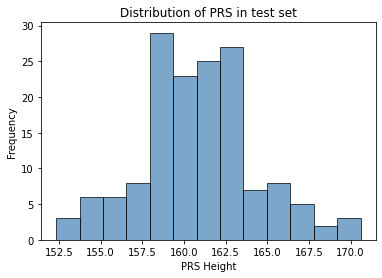

In [67]:
# Assuming you have a pandas DataFrame called test_merged_df_final
height = test_merged_df_final['Predicted_PRS']

# Create a histogram of the Height_y column
plt.hist(height, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')

# Set titles and labels
plt.title('Distribution of PRS in test set')
plt.xlabel('PRS Height')
plt.ylabel('Frequency')

# Show the plot
plt.show()


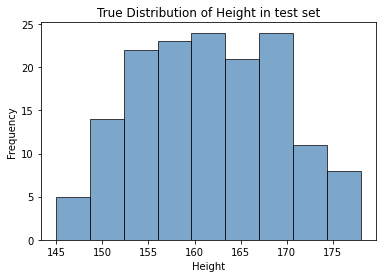

In [68]:
# Assuming you have a pandas DataFrame called test_merged_df_final
height = test_merged_df_final['Height_y']

# Create a histogram of the Height_y column
plt.hist(height, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')

# Set titles and labels
plt.title('True Distribution of Height in test set')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Show the plot
plt.show()


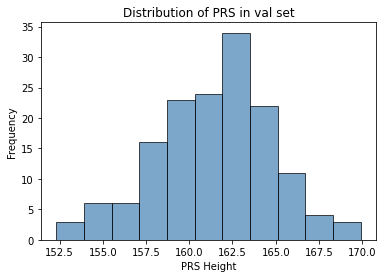

In [69]:
# Assuming you have a pandas DataFrame called test_merged_df_final
height_val = val_merged_df_final['Predicted_PRS']

# Create a histogram of the Height_y column
plt.hist(height_val, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')

# Set titles and labels
plt.title('Distribution of PRS in val set')
plt.xlabel('PRS Height')
plt.ylabel('Frequency')

# Show the plot
plt.show()


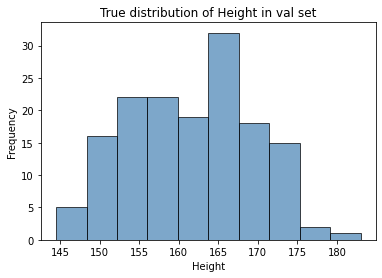

In [70]:
# Assuming you have a pandas DataFrame called test_merged_df_final
height_val = val_merged_df_final['Height_y']

# Create a histogram of the Height_y column
plt.hist(height_val, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')

# Set titles and labels
plt.title('True distribution of Height in val set')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [76]:
y_test = test_merged_df_final['Height_y']
y_val = val_merged_df_final['Height_y']

In [77]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, predictions_test)
print("R-squared on the test set: ", r2_test)

r2_val = r2_score(y_val, predictions_val)
print("R-squared on the validation set: ", r2_val)


R-squared on the test set:  -0.1338954505868699
R-squared on the validation set:  -0.21929074725533315


In [80]:
def get_model_performance(model, X, y, snps):
    dmatrix = xgb.DMatrix(X[snps])
    predictions = model.predict(dmatrix)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    return mse, r2

mse_vals = []
r2_vals = []
mse_tests = []
r2_tests = []

for model, snps, _ in models_snps_coefficients_0:
    mse_val, r2_val = get_model_performance(model, X_val, y_val, snps)
    mse_test, r2_test = get_model_performance(model, X_test, y_test, snps)

    mse_vals.append(mse_val)
    r2_vals.append(r2_val)
    mse_tests.append(mse_test)
    r2_tests.append(r2_test)

print("Mean Squared Error on the validation set for each model: ", mse_vals)
print("R-squared on the validation set for each model: ", r2_vals)
print("Mean Squared Error on the test set for each model: ", mse_tests)
print("R-squared on the test set for each model: ", r2_tests)


Mean Squared Error on the validation set for each model:  [78.55791598584865, 88.2686539504049]
R-squared on the validation set for each model:  [-0.29285222570561587, -0.4526648815426437]
Mean Squared Error on the test set for each model:  [70.62455224568767, 77.27719955769336]
R-squared on the test set for each model:  [-0.24030607952329075, -0.35713965430193695]


In [81]:
import matplotlib.pyplot as plt

def plot_distributions(predictions_test, predictions_val, test_pheno, val_pheno, model_name):
    # Build the final DataFrames for test and validation sets
    final_test_df = build_final_df(phenotype_df_test, predictions_test, 'Test', FIDs_test)
    final_val_df = build_final_df(phenotype_df_val, predictions_val, 'Validation', FIDs_val)

    test_merged_df_final = final_test_df.merge(test_pheno[['FID', 'Height']], on='FID', how='left')
    val_merged_df_final = final_val_df.merge(val_pheno[['FID', 'Height']], on='FID', how='left')

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{model_name} Distributions')

    # Distribution of PRS in the test set
    axes[0, 0].hist(test_merged_df_final['Predicted_PRS'], bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of PRS in test set')
    axes[0, 0].set_xlabel('PRS height')
    axes[0, 0].set_ylabel('Frequency')

    # True Distribution of Height in the test set
    axes[0, 1].hist(test_merged_df_final['Height_y'], bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 1].set_title('True Distribution of Height in test set')
    axes[0, 1].set_xlabel('Height')
    axes[0, 1].set_ylabel('Frequency')

    # Distribution of PRS in the validation set
    axes[1, 0].hist(val_merged_df_final['Predicted_PRS'], bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
    axes[1, 0].set_title('Distribution of PRS in val set')
    axes[1, 0].set_xlabel('PRS height')
    axes[1, 0].set_ylabel('Frequency')

    # True distribution of Height in the validation set
    axes[1, 1].hist(val_merged_df_final['Height_y'], bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
    axes[1, 1].set_title('True distribution of Height in val set')
    axes[1, 1].set_xlabel('Height')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Call the function for each model, providing the necessary data
# Assuming your models are stored in `my_models_0`
for i, model in enumerate(my_models_0, 1):
    # Get predictions for test and validation sets
    predictions_test = model.predict(phenotype_df_test)
    predictions_val = model.predict(phenotype_df_val)

    # Call the plot_distributions function for the current model
    plot_distributions(predictions_test, predictions_val, test_pheno, val_pheno, f'Model {i}')



TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)